In [1]:

from IPython.display import clear_output
#from ipywidgets import interact, IntSlider

import os, os.path, shutil
import zipfile
import random
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import music21
import pypianoroll
import pretty_midi
import seaborn as sns
import sys


from pypianoroll import Multitrack, Track
from tqdm import tqdm
from music21 import *
from typing import Tuple
from torch import Tensor
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset
from collections import Counter


#import itertools
#import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
#import moviepy.editor as mpy
#import music21
#from IPython import display
#import seaborn as sns

Paths to Directories

In [2]:
root_dir = './'

#Directory to save model data
model_dir = os.path.join(root_dir, 'model')

#Directory to the JSB dataset used to train and evaluate the model
dataset_dir = os.path.join(root_dir, 'Dataset/Jsb16thSeparated.npz')

dataset_eval_midi = os.path.join(root_dir, 'Dataset/eval/bevmidi')

bench_eval_midi = os.path.join(root_dir, 'Dataset/eval/benchmidi')

#Directory to the alternate dataset used to draw inference from the Mahalanobis distance evaluation
mEval_altDataset = os.path.join(root_dir, 'Dataset/eval/revmidi')

#Directory to save midi files during training
train_out_dir = os.path.join(model_dir, 'train_out/midi')

#Directory to save pianoroll images during training
train_out_dir_p = os.path.join(model_dir, 'train_out/pianorolls')

#Directory to save midi files during inference
test_out_dir = os.path.join(model_dir, 'test_out/midi')

#Directory to save pianoroll and score images during inference
test_out_dir_p = os.path.join(model_dir, 'test_out/rollsandscores')


os.makedirs(train_out_dir, exist_ok=True)
os.makedirs(train_out_dir_p, exist_ok=True)
os.makedirs(test_out_dir, exist_ok=True)
os.makedirs(test_out_dir_p, exist_ok=True)

In [3]:
sys.path.insert(0, 'Utils')

import settings, data_preprocessing, get_samples, training_sample_history, mahalanobis_distance, bach_eval #visualisations

Dataset Preprocessing and Organisation

In [4]:
from torch.utils import data
from numpy.core.fromnumeric import shape

train = data_preprocessing.MidiDataset(dataset_dir).data_binary
test = data_preprocessing.MidiDataset(dataset_dir, split='test').data_binary
valid = data_preprocessing.MidiDataset(dataset_dir, split='valid').data_binary
ev = np.concatenate([train, test])

print(test[0].shape)

mEvalData = data_preprocessing.save_pianoroll_as_midi(ev)[0]

#i = 0
#for p in mEvalData:

    #p.write(os.path.join(dataset_eval_midi, 'bevmidi%s.mid' % i))
    #i = i+1


data, sData = data_preprocessing.save_pianoroll_as_midi(train)

vData, sVData = data_preprocessing.save_pianoroll_as_midi(valid)

testData, sTestData = data_preprocessing.save_pianoroll_as_midi(test)



(128, 84, 4)


SAMPLE COLLECTION

In [6]:
dataT = get_samples.Get_Samples(data)
dataS = get_samples.Get_Samples(sData)
dataVS = get_samples.Get_Samples(sVData)

100%|██████████| 228/228 [00:00<00:00, 2400.01it/s]


Successfully collect 912 samples from 228 songs
Data shape : (912, 4, 32, 84)
(912, 4, 32, 84)


100%|██████████| 228/228 [00:00<00:00, 7564.36it/s]


Successfully collect 912 samples from 228 songs
Data shape : (912, 1, 32, 84)
(912, 1, 32, 84)


100%|██████████| 75/75 [00:00<00:00, 6249.58it/s]

Successfully collect 300 samples from 75 songs
Data shape : (300, 1, 32, 84)
(300, 1, 32, 84)


In [8]:
dataT = []

for multitrack in tqdm(data):

    multitrack.binarize()
        # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(beat_resolution)
        # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)

        # Get the target pitch range only
    pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + (n_pitches + 1)] 
    #print(pianoroll.shape) 
        # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    stepsPerSample = n_measures * measure_resolution
        # Randomly select a number of phrases from the multitrack pianoroll
    for idx in range(7):   #np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
            continue
        dataT.append(pianoroll[:, start:end])
# Stack all the collected pianoroll segments into one big array
#random.shuffle(dataS)
dataT = np.stack(dataT)
print(f"Successfully collect {len(dataT)} samples from {len(data)} songs")
print(f"Data shape : {dataT.shape}")
print(dataT.shape)


100%|██████████| 228/228 [00:00<00:00, 1853.70it/s]

Successfully collect 1596 samples from 228 songs
Data shape : (1596, 4, 32, 84)
(1596, 4, 32, 84)


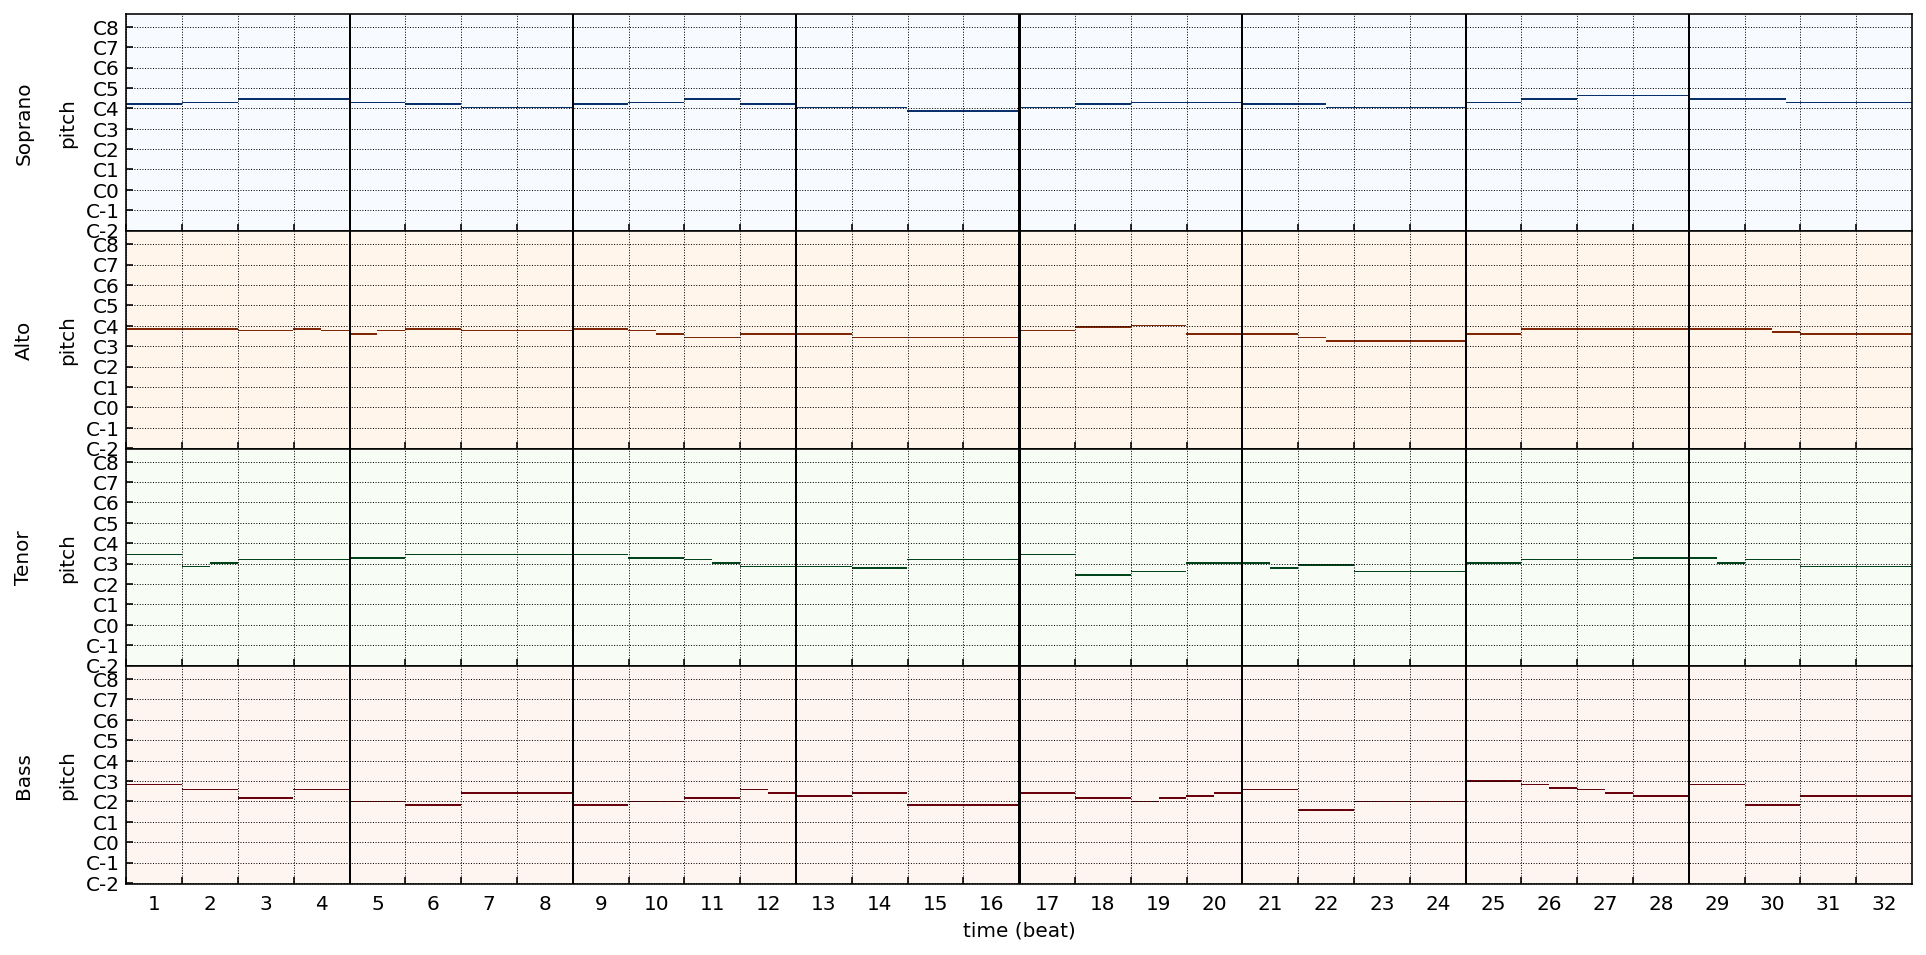

In [8]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(dataT[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - (n_pitches + 1) ))) #
    tracks.append(pypianoroll.BinaryTrack(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
multitrack.write('./midiDataset/test3.mid')
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 2 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [7]:
dataT = torch.as_tensor(dataT, dtype=torch.float32)
dataS = torch.as_tensor(dataS, dtype=torch.float32)
dataVS = torch.as_tensor(dataVS, dtype=torch.float32)

dataset_ = torch.utils.data.TensorDataset(dataT, dataS)
datasetV_ = torch.utils.data.TensorDataset(dataVS)

data_loader = torch.utils.data.DataLoader(
    dataset_, batch_size=settings.batch_size, drop_last=True, shuffle=True)
data_loader_V = torch.utils.data.DataLoader(
    datasetV_, batch_size=4, drop_last=True, shuffle=False)

MODEL

In [8]:
class GeneratorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride, conditioned=False):
        super().__init__()

        if conditioned == False:
            self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
            self.batchnorm = torch.nn.BatchNorm3d(out_dim)

        else:
            self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
            self.batchnorm = torch.nn.BatchNorm3d(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        return torch.nn.functional.relu(x)

In [9]:
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = GeneratorBlock(1, 16, (2, 1, 1), (2, 1, 1))
        self.transconv1 = GeneratorBlock(16, 32, (1, 4, 4), (1, 4, 4))
        self.transconv2 = GeneratorBlock(32, 64, (1, 2, 7), (1, 2, 7))
        self.transconv3 = GeneratorBlock(64, 128, (1, 2, 3), (1, 2, 3))
        self.transconv4 = torch.nn.ModuleList([
            GeneratorBlock(256, 64, (2, 4, 14), (2, 4, 14), conditioned=True)
            for _ in range(settings.n_tracks - 1)
        ])
        self.transconv5 = torch.nn.ModuleList([
            GeneratorBlock(64, 1, (1, 4, 6), (1, 4, 6), conditioned=True)
            for _ in range(settings.n_tracks - 1)
        ])

    def forward(self, z, y):    
      z = z.view(-1, settings.latent_dim, 1, 1, 1)
      y = y.view(-1, 1, settings.n_measures, settings.measure_resolution, (settings.n_pitches + 1))
      x = self.transconv0(y)
      x = self.transconv1(x)
      x = self.transconv2(x)
      x = self.transconv3(x)
      x = torch.cat((x, z), dim=1)
      x = [transconv(x) for transconv in self.transconv4]
      x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)], 1)
      x = torch.cat((y, x), dim=1)
      x = x.view(-1, settings.n_tracks, settings.n_measures * settings.measure_resolution, (settings.n_pitches + 1))

      return x

In [10]:
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [11]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)

In [12]:
class Discriminator(torch.nn.Module):
    """A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self):
        super().__init__()
        self.conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12)) for _ in range(settings.n_tracks)
        ])
        self.conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 16, (1, 4, 1), (1, 4, 1)) for _ in range(settings.n_tracks)
        ])
        self.conv2 = DiscriminatorBlock(16 * 4, 64, (1, 1, 3), (1, 1, 1))
        self.conv3 = DiscriminatorBlock(64, 64, (1, 1, 4), (1, 1, 4))
        self.conv4 = DiscriminatorBlock(64, 128, (1, 4, 1), (1, 4, 1))
        self.conv5 = DiscriminatorBlock(128, 128, (2, 1, 1), (1, 1, 1))
        self.conv6 = DiscriminatorBlock(128, 256, (1, 1, 1), (3, 1, 1))
        self.dense = torch.nn.Linear(256, 1)

    def forward(self, x, y):
        x = x.view(-1, settings.n_tracks, settings.n_measures, settings.measure_resolution, (settings.n_pitches + 1))
        y = y.view(-1, 1, settings.n_measures, settings.measure_resolution, (settings.n_pitches + 1))
        x = torch.cat((x, y), dim=1)
        x = [conv(x[:, [i]]) for i, conv in enumerate(self.conv0)]
        x = torch.cat([conv(x_) for x_, conv in zip(x, self.conv1)], 1)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 256)
        x = self.dense(x)
        return x

In [13]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, labels):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates, labels)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1).cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [14]:
def train_one_step(d_optimizer, g_optimizer, real_samples, labels):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(settings.batch_size, settings.latent_dim)

    #print(latent.shape)

    # Transfer data to GPU
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        labels = labels.cuda()
        latent = latent.cuda()

    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples, labels)
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent, labels)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach(), labels)
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data, labels.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples, labels)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

In [15]:
# Create data loader
# data_loader = get_data_loader()

# Create neural networks
discriminator = Discriminator()
generator = Generator()
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(settings.n_samples, settings.latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create an empty dictionary to store history samples
history_samples = {}

# Create a LiveLoss logger instance for monitoring

# Initialize step
step = 0

Number of parameters in G: 5596985
Number of parameters in D: 134401


TRAINING

(d_loss=-3.643520, g_loss=-1.700940): 100%|█| 1000/1000 [01:25<00:00, 11.69it/s]

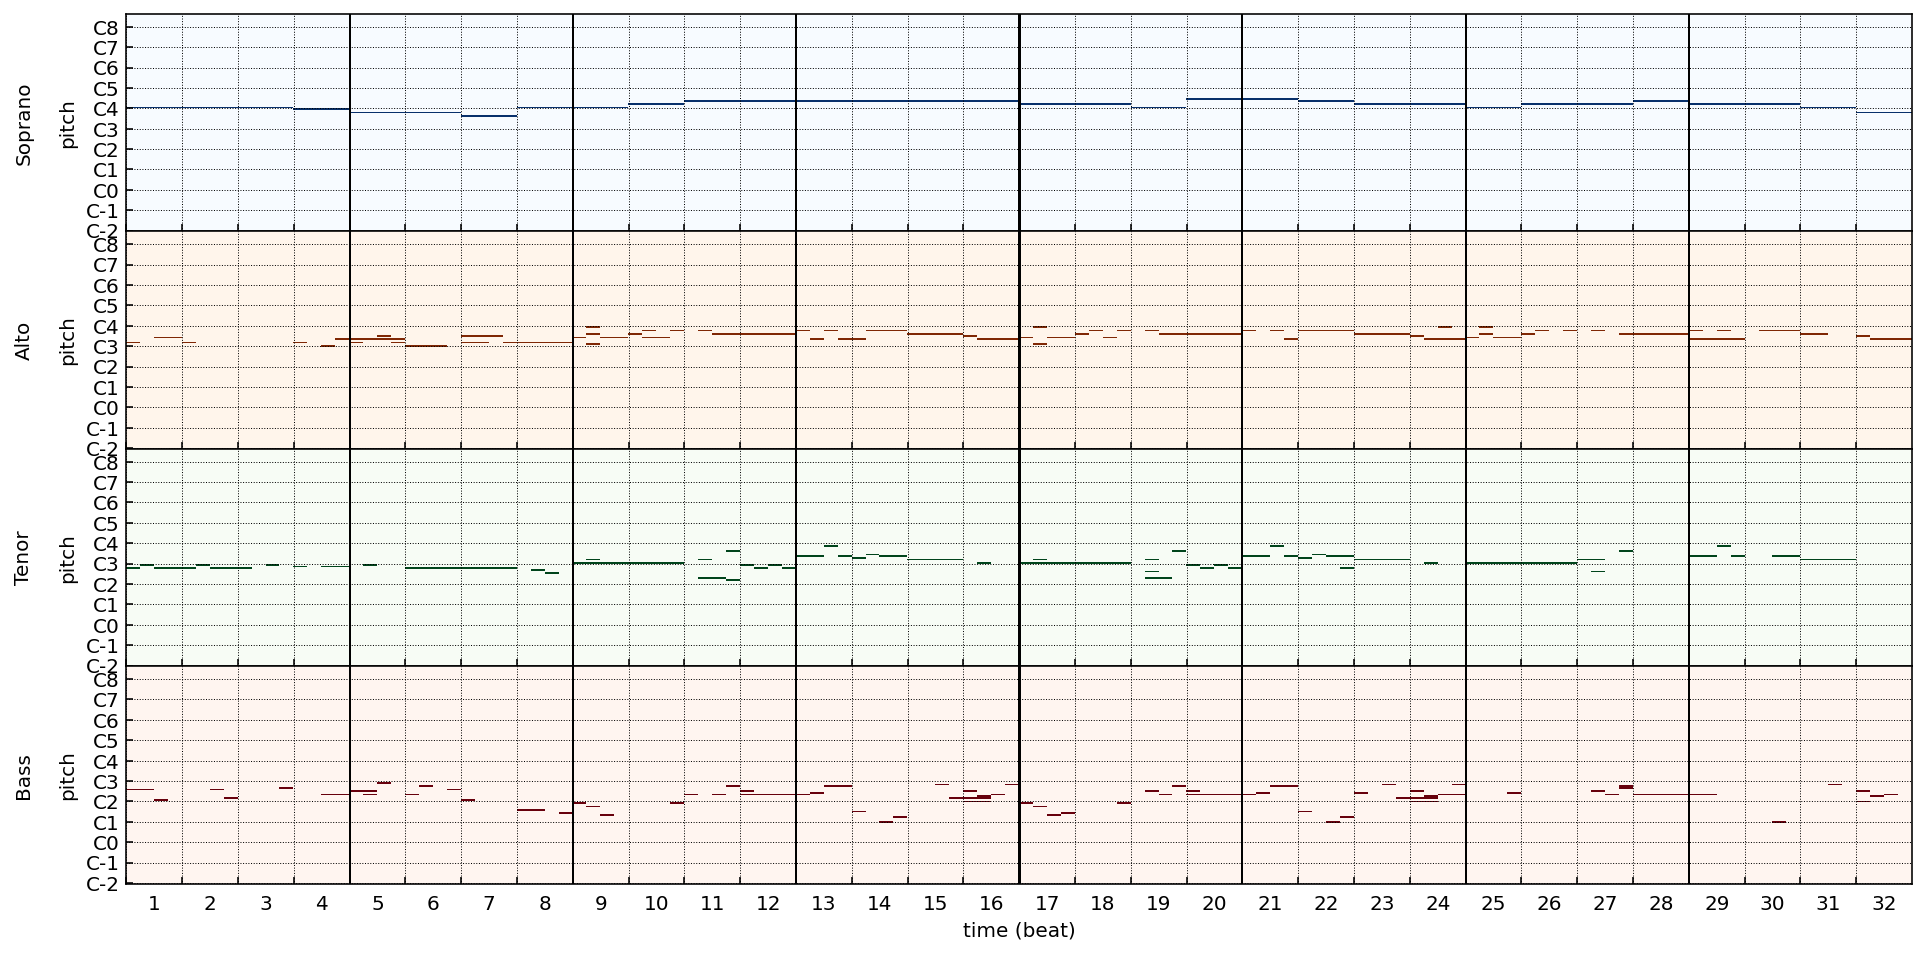

In [16]:
# Create a progress bar instance for monitoring
progress_bar = tqdm(total=settings.n_steps, initial=step, ncols=80, mininterval=1)

d_losses = []
g_losses = []

# Start iterations
while step < settings.n_steps + 1:
    # Iterate over the dataset
    for real_samples, labels in data_loader:
        #for labels in data_loader_S:
            #print(data)
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples, labels)

        d_loss = d_loss.cpu().detach().numpy()
        g_loss = g_loss.cpu().detach().numpy()

    
    # Update losses to progress bar
        progress_bar.set_description_str(
            "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
    
        if step % settings.sample_interval == 0:

            d_losses.append(d_loss)
            g_losses.append(g_loss)
        # Get generated samples
            random_idx = np.random.choice(len(dataVS), settings.n_samples, replace=False)
            vLabels = dataVS[0:4].cuda()
            generator.eval()
            samples = generator(sample_latent, vLabels).cpu().detach().numpy()
            history_samples[step] = samples

            #Display loss curves
            #clear_output(True)
            #if step > 0:
              #liveloss.send()
        
            
        
        step += 1
        progress_bar.update(1)
        if step >= settings.n_steps:
            break

# Display generated samples
samplesT = samples.transpose(1, 0, 2, 3).reshape(settings.n_tracks, -1, (settings.n_pitches+1))
tracks = []
for idx, (program, is_drum, track_name) in enumerate(
    zip(settings.programs, settings.is_drums, settings.track_names)
):
    pianoroll = np.pad(
        samplesT[idx] > 0.5,
        ((0, 0), (settings.lowest_pitch, 128 - settings.lowest_pitch - (settings.n_pitches+1)))
    )
    tracks.append(
        pypianoroll.BinaryTrack(
            name=track_name,
            program=program,
            is_drum=is_drum,
            pianoroll=pianoroll
        )
    )
m = Multitrack(
tracks=tracks,
tempo=settings.tempo_array,
resolution=settings.beat_resolution
)

m.write('./test.mid')
axs = m.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(
        settings.measure_resolution,
        4 * settings.measure_resolution * settings.n_measures,
        settings.measure_resolution
    ):
        if x % (settings.measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()


PLOT LOSSES

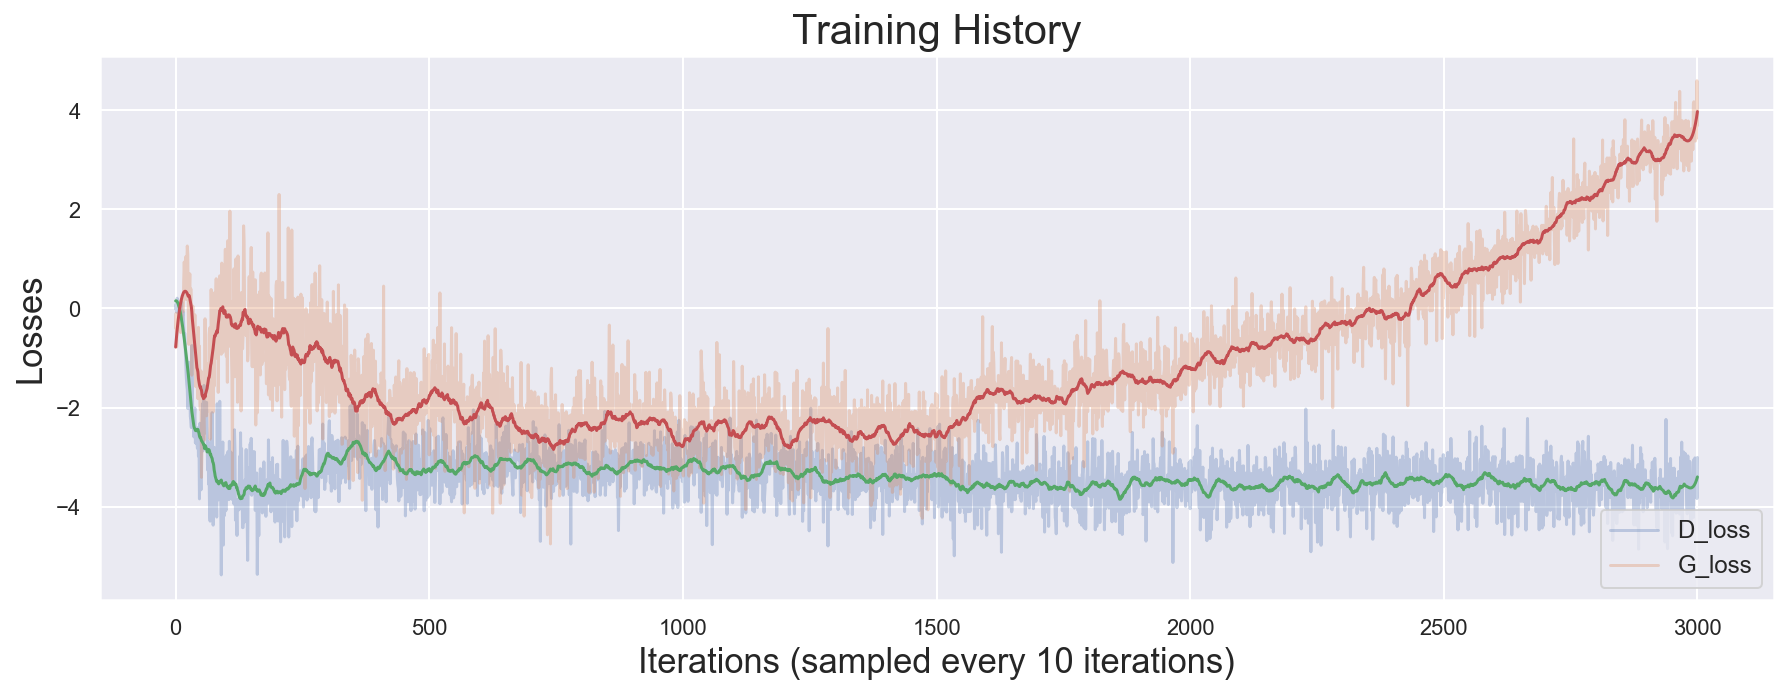

In [18]:
from scipy.signal import savgol_filter

def plot_loss_logs(G_loss, D_loss, figSize=(15, 5)):

    plt.ion()
    sns.set()
    plt.figure(figsize=figSize)
    plt.plot(D_loss, alpha=0.3, label='D_loss')
    plt.plot(G_loss, alpha=0.3, label='G_loss')
    plt.plot(savgol_filter(D_loss, 51, 3))
    plt.plot(savgol_filter(G_loss, 51, 3))
    plt.legend(loc='lower right', fontsize='medium')
    plt.xlabel('Iterations (sampled every 10 iterations)', fontsize='x-large')
    plt.ylabel('Losses', fontsize='x-large')
    plt.title('Training History', fontsize='xx-large')
    plt.savefig(os.path.join(train_out_dir_p, 'model_loss.png'))
    

plot_loss_logs(g_losses, d_losses, figSize=(15, 5))

TRAINING SAMPLE HISTORY

Step=0


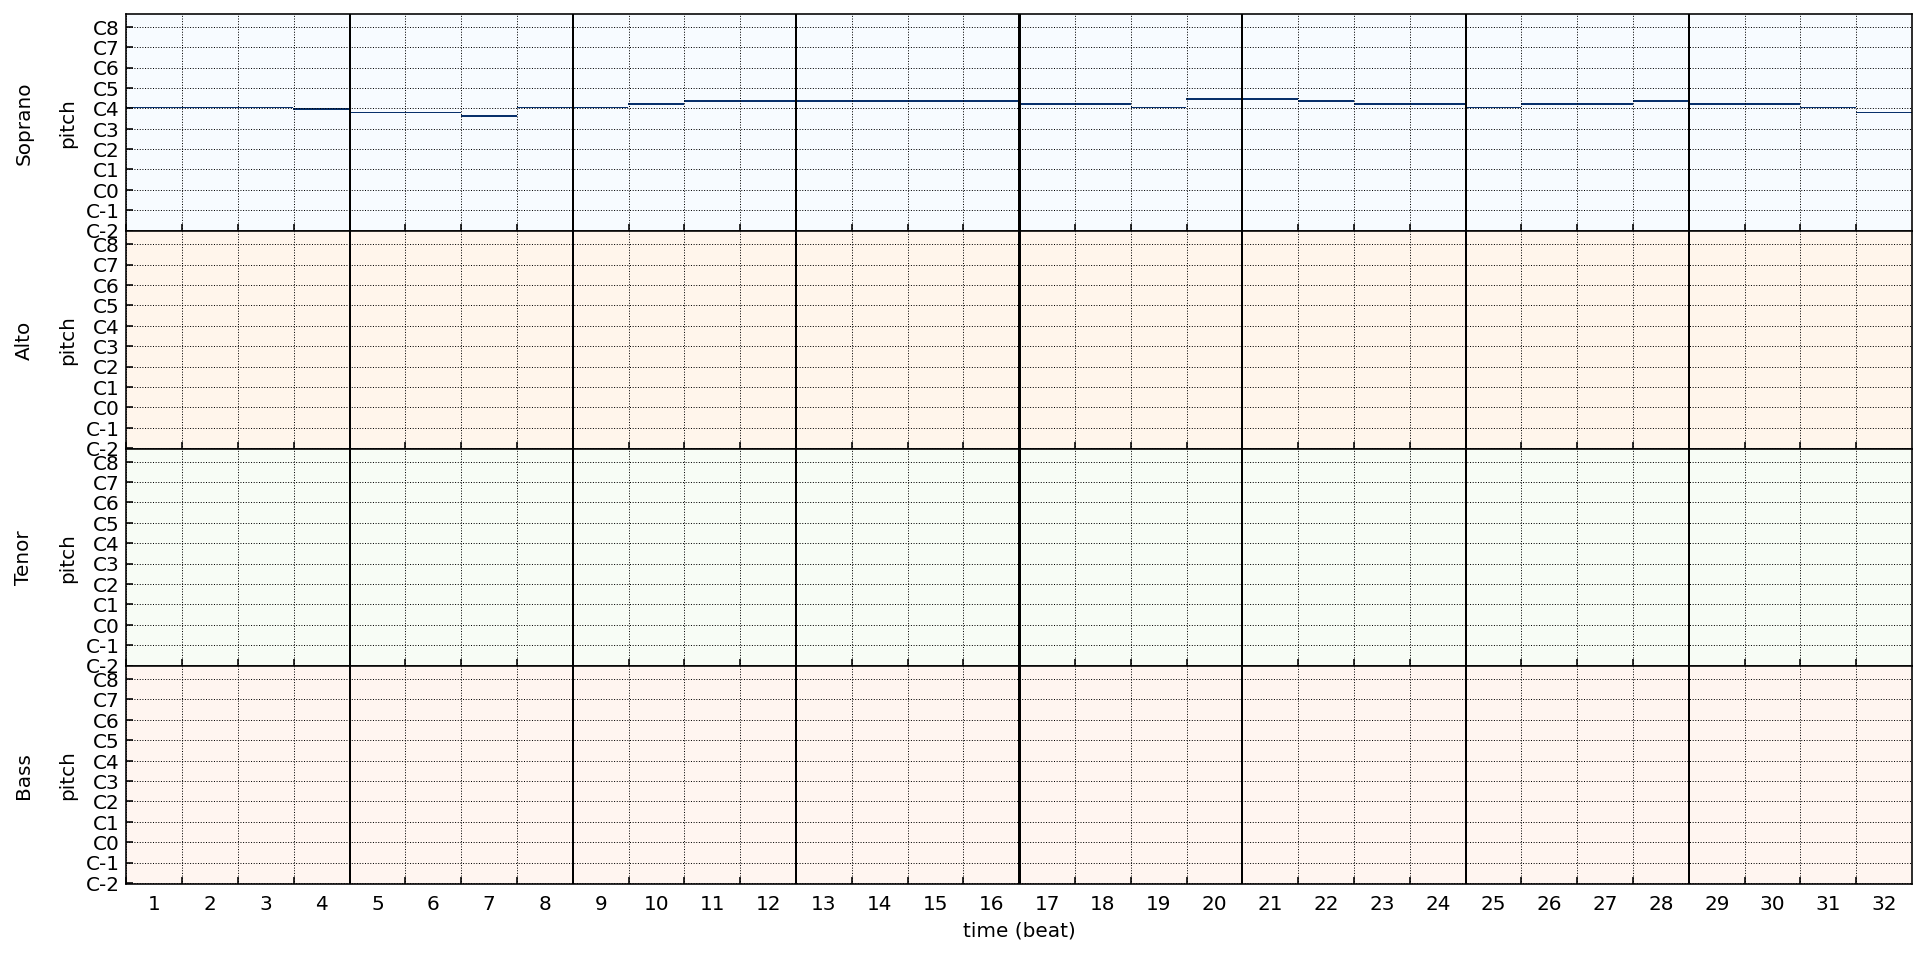

Step=10


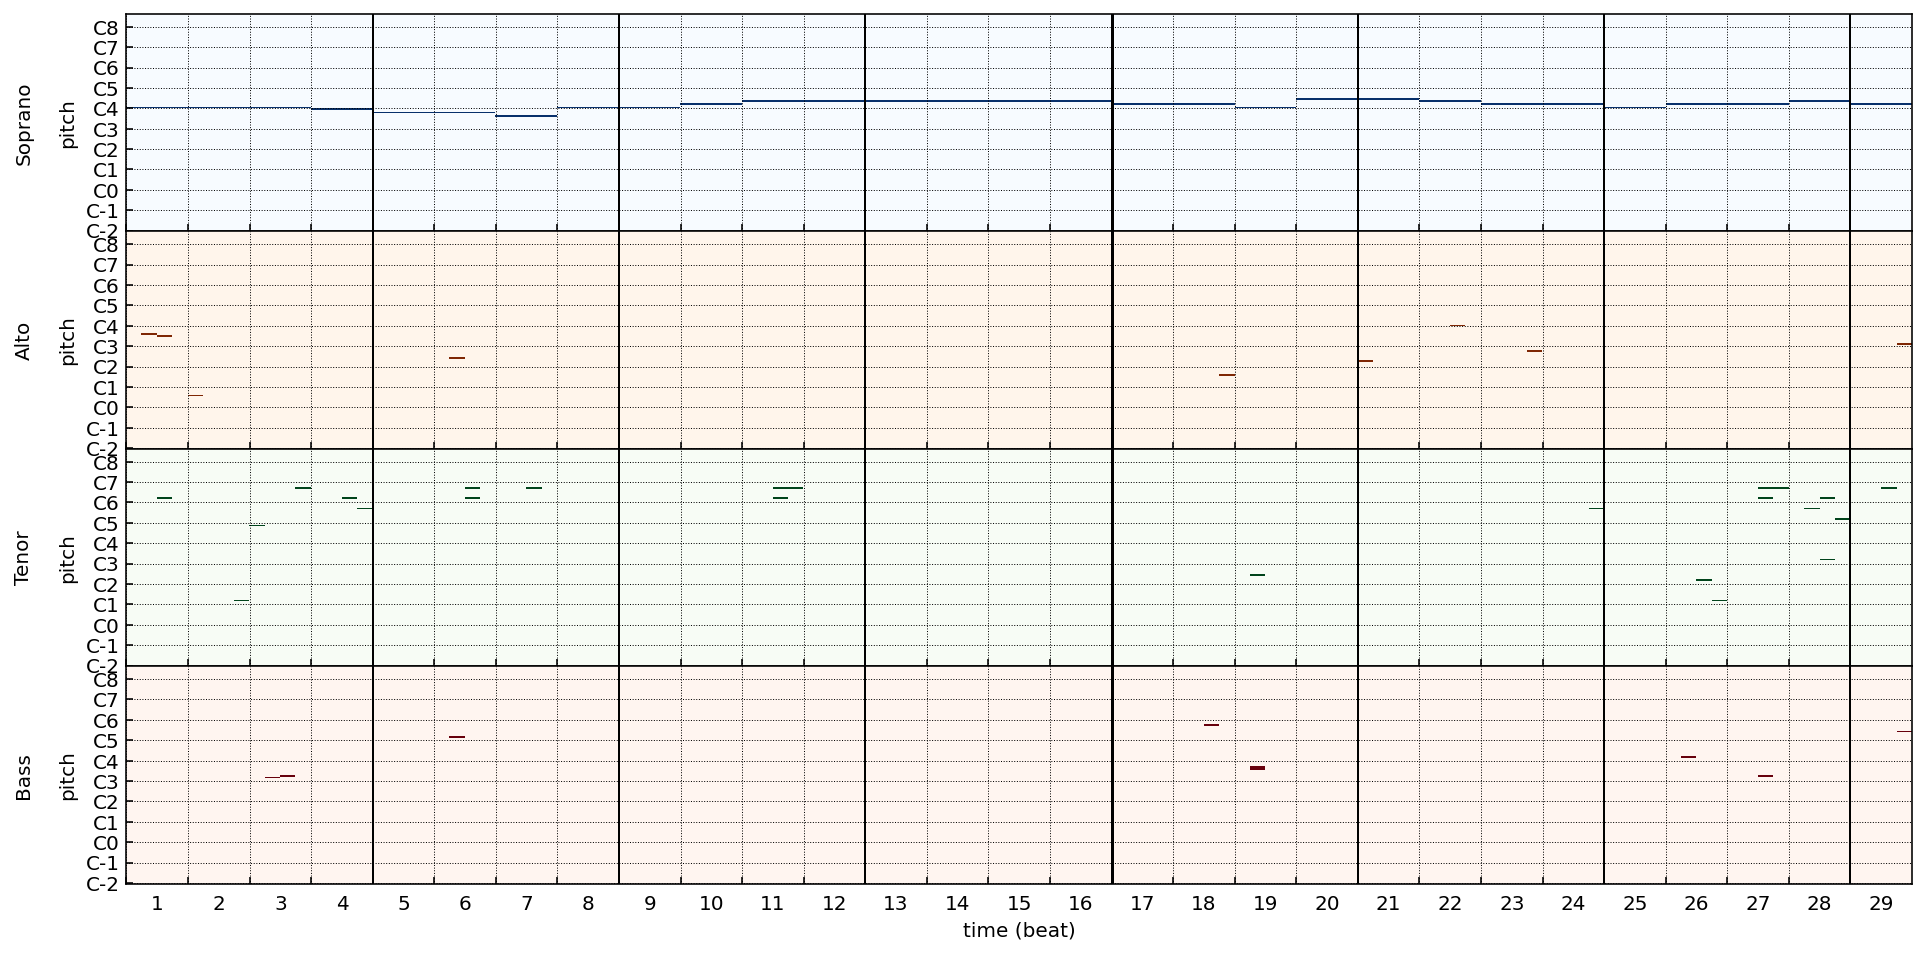

Step=100


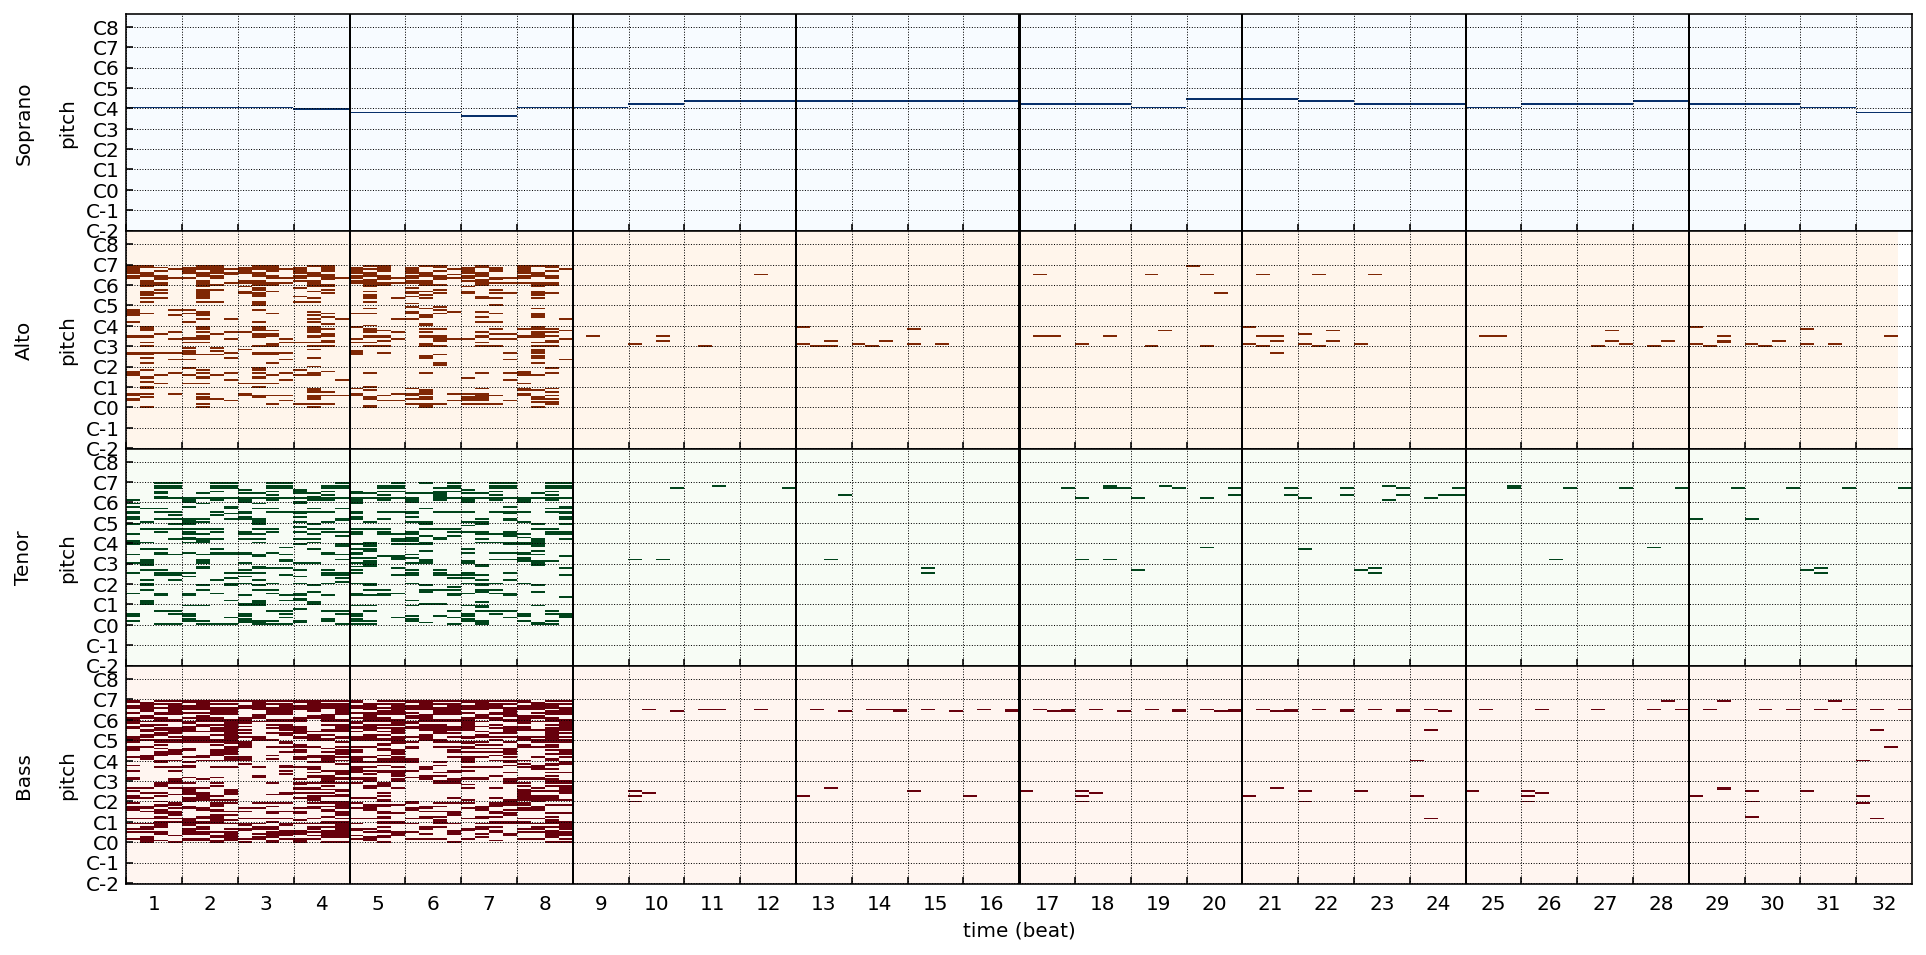

Step=1000


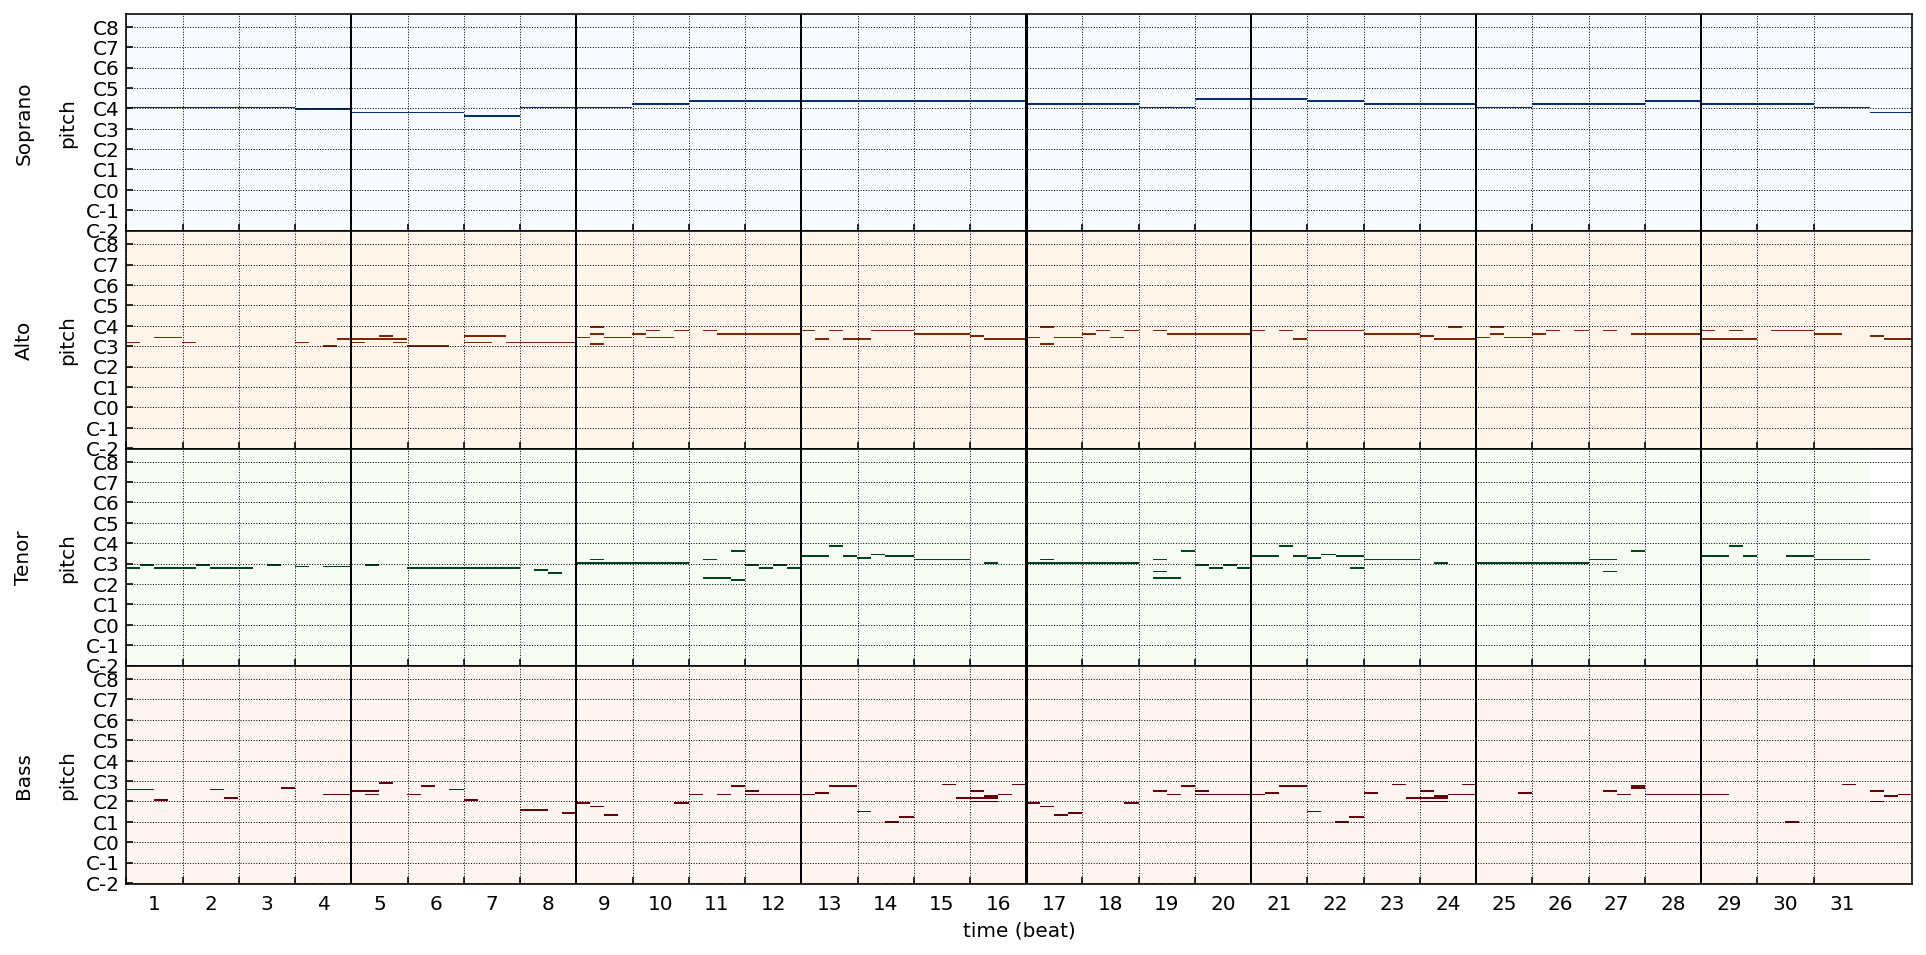

Step=1000


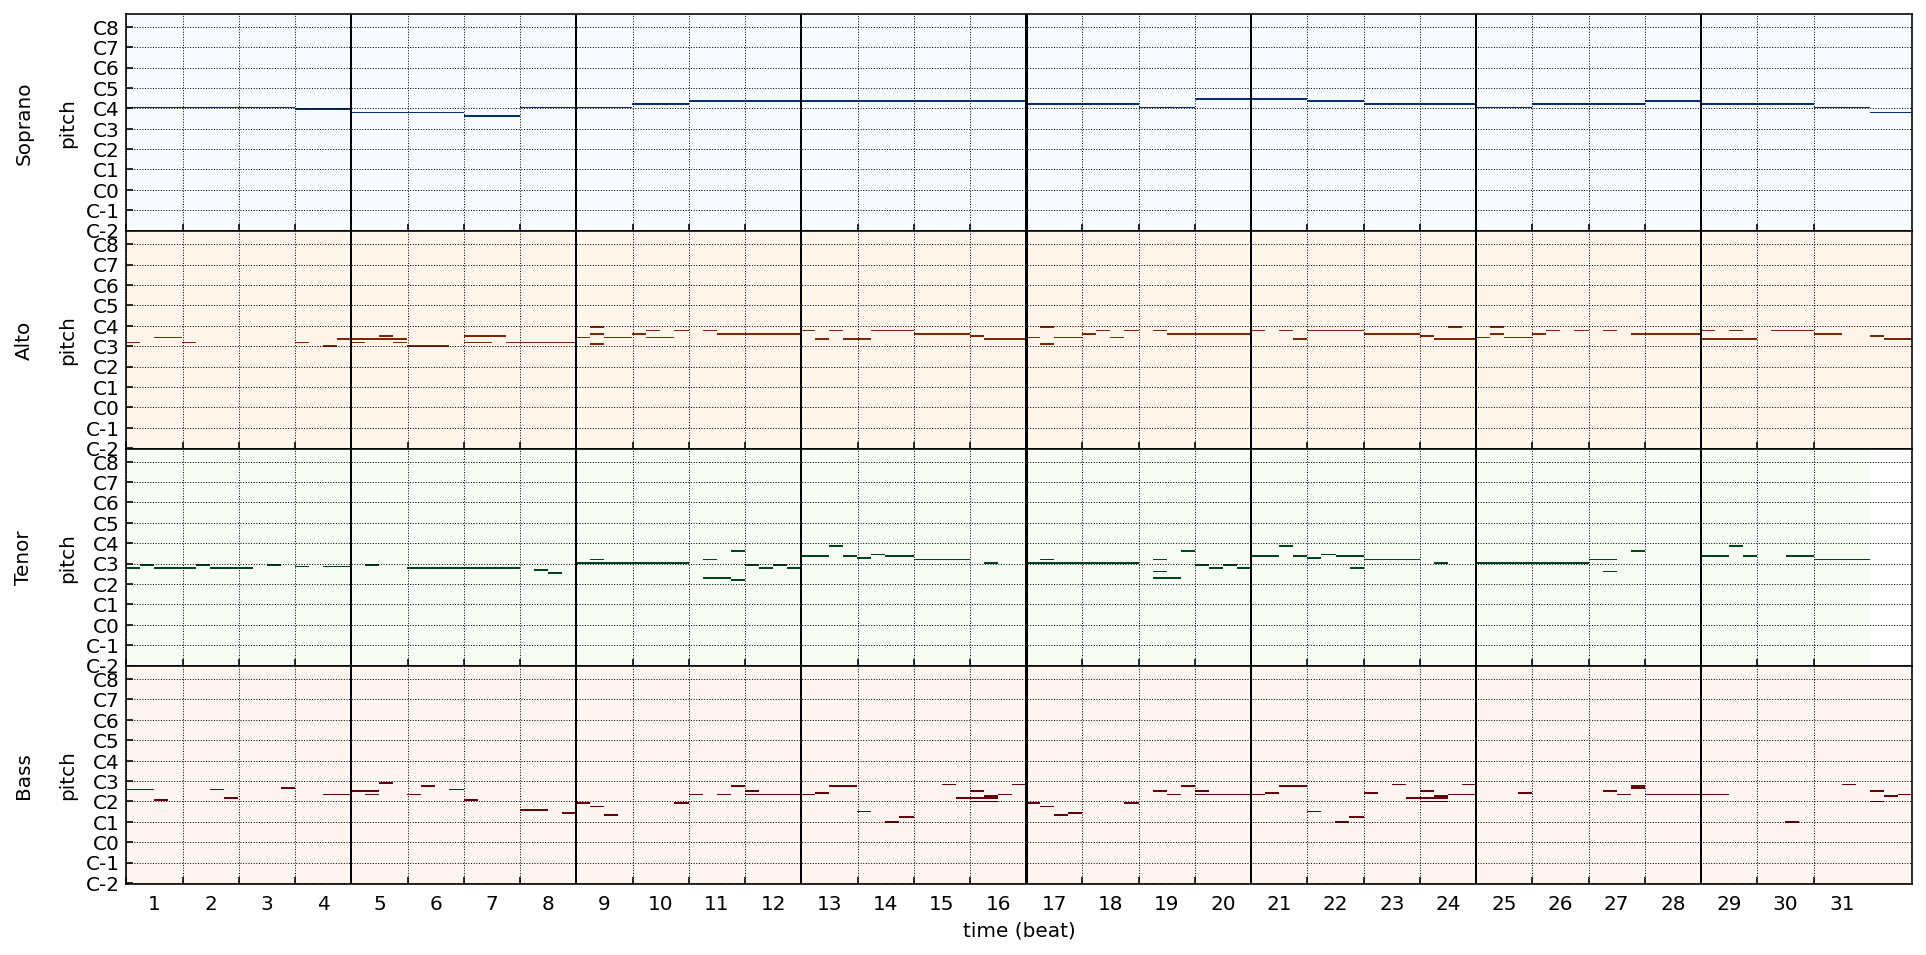

In [17]:
training_sample_history.Show_History(history_samples, train_out_dir, train_out_dir_p)

INFERENCE

In [19]:
i = 0

testPRoll = []
for v in data_loader_V:

    generator.eval().cpu()
    
    v = v[0].cpu()
    sample_latent = sample_latent.cpu()
    samplesI = generator(sample_latent, v).cpu().detach().numpy()

    samplesIT = samples.transpose(1, 0, 2, 3).reshape(settings.n_tracks, -1, (settings.n_pitches+1))
    tracks = []
    for idx, (program, is_drum, track_name) in enumerate(
        zip(settings.programs, settings.is_drums, settings.track_names)
    ):
        pianoroll = np.pad(
            samplesIT[idx] > 0.5,
            ((0, 0), (settings.lowest_pitch, 128 - settings.lowest_pitch - (settings.n_pitches+1)))
        )
        tracks.append(
            pypianoroll.BinaryTrack(
                name=track_name,
                program=program,
                is_drum=is_drum,
                pianoroll=pianoroll
            )
        )
    m = Multitrack(
    tracks=tracks,
    tempo=settings.tempo_array,
    resolution=settings.beat_resolution
    )

    testPRoll.append(m)

    m.write(os.path.join(test_out_dir, 'omid%s.mid' % i))
    i = i+1
    

In [21]:
#torch.save(generator, "D:\Github\outputs\potentialData1\Gen7\generator.pth")

PLOT INFERENCE LOSSES

EVALUATION

    Mahalanobis Distance:

In [23]:
c = 0
for i in vData:

    i.write(r"D:\Github\HonoursProject-reharmonisationGAN\Dataset\eval\benchmidi\vmidi%s.mid" % c)
    c=c+1

[9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749771457, 9.121632749

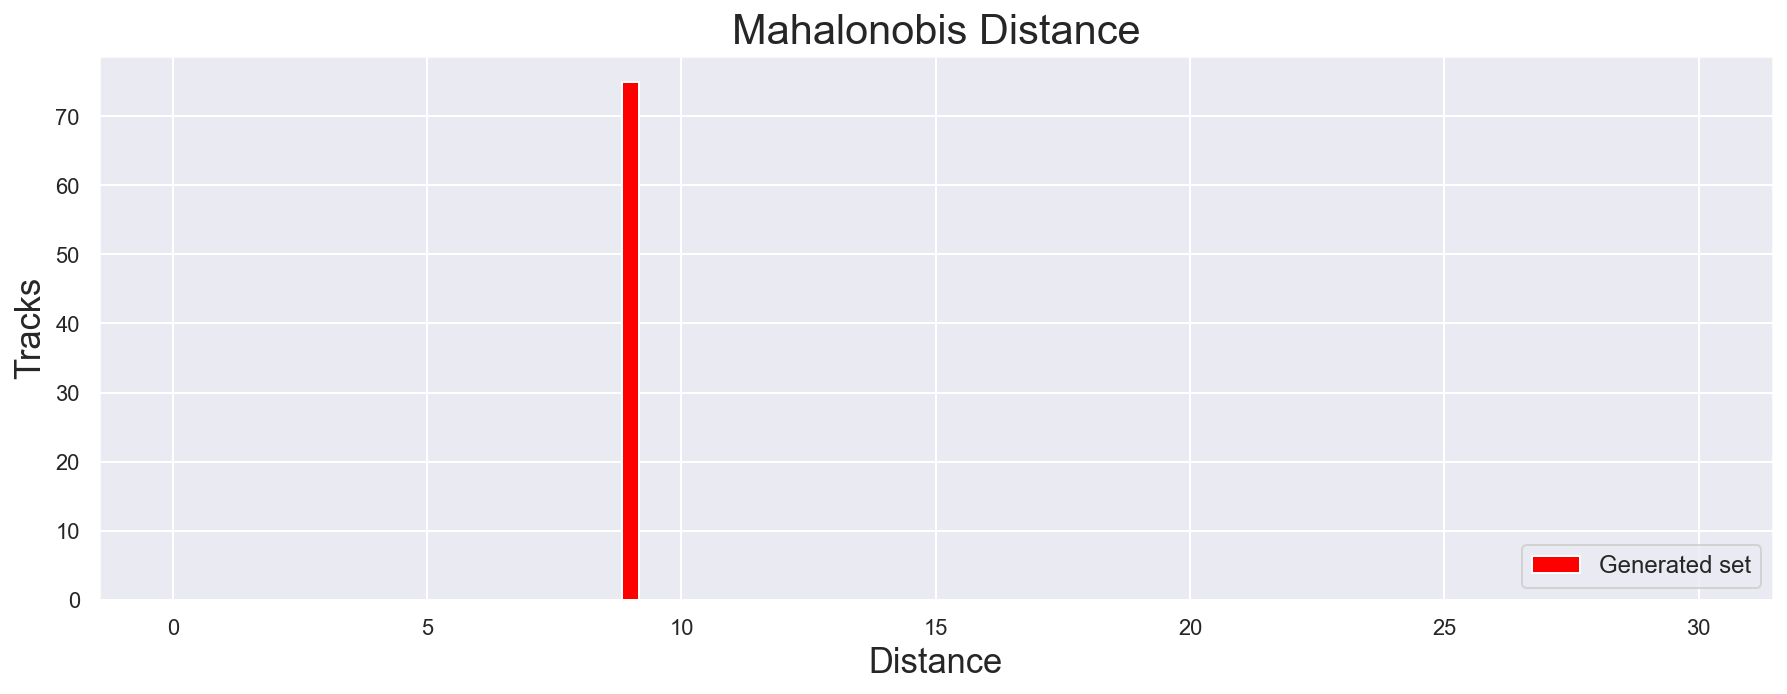

In [20]:
mahaData = []

for file in os.listdir(test_out_dir):

   f = os.path.join(test_out_dir, file)  #unit test for correct file extension/null files # Bug where evaluation can't be run twice in the same session
   
   maha = mahalanobis_distance.Evaluate.Mahalanobis_Distance(f, dataset_eval_midi)
   
   mahaData.append(maha[0])


mahaMax = max(mahaData)
mahaMin = min(mahaData)
mahaDataM = np.mean(mahaData)

print(mahaData)
print()
print("Mean Distance: %s" % (mahaDataM))
print()
print("Max Distance: %s" % (mahaMax))
print()
print("Min Distance: %s" % (mahaMin))

range = (0, 30)
bins = 75

plt.ion()
sns.set()
plt.figure(figsize=(15, 5))
plt.hist(mahaData, bins, range, color = 'red', histtype = 'bar', rwidth = 0.8, label='Generated set')
plt.legend(loc='lower right', fontsize='medium')
plt.xlabel('Distance', fontsize='x-large')
plt.ylabel('Tracks', fontsize='x-large')
plt.title('Mahalonobis Distance', fontsize='xx-large')


plt.show()

    Bach Harmonisation Evaluation:

In [5]:
b = music21.converter.parse(r"D:\Github\HonoursProject-reharmonisationGAN\test.mid")

In [6]:
bach_eval.Chord_Analysis(b)
bach_eval.Cadences(b)
bach_eval.Consecutive_intervals(b)
bach_eval.Voice_Leading(b)
bach_eval.Voice_Ranges(b)
bach_eval.Chord_Analysis(b)

Number of typical chords found in a Bach chorale: 

major triad 0
minor triad 1
major seventh chord 0
minor seventh chord 0
dominant seventh chord 0
diminished triad 1

for the key of a minor, the following chord positions were used: 

i 4
ii 2
III 0
iv 4
v 5
VI 1
VII 0

{'major triad': 0, 'minor triad': 1, 'major seventh chord': 0, 'minor seventh chord': 0, 'dominant seventh chord': 0, 'diminished triad': 1}
{'i': 4, 'ii': 2, 'III': 0, 'iv': 4, 'v': 5, 'VI': 1, 'VII': 0}
Consecutive Intervals Check Results: 

ERROR! the number of notes at a timestep should not be greater than the number of voices.
ERROR! the number of notes at a timestep should not be greater than the number of voices.
ERROR! the number of notes at a timestep should not be greater than the number of voices.
ERROR! the number of notes at a timestep should not be greater than the number of voices.
ERROR! the number of notes at a timestep should not be greater than the number of voices.
Consecutive fifth found in measure

({'major triad': 0,
  'minor triad': 1,
  'major seventh chord': 0,
  'minor seventh chord': 0,
  'dominant seventh chord': 0,
  'diminished triad': 1},
 {'i': 4, 'ii': 2, 'III': 0, 'iv': 4, 'v': 5, 'VI': 1, 'VII': 0})